In [1]:
import jax
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt



In [180]:

def create_noise(x_min, x_max, num_steps_x, y_min, y_max, num_steps_y, key):  

    #code from 1D solution changed to work in 2D
    N_x = int(num_steps_x)
    N_y = int(num_steps_y)

    #create noise 
    amplitude = 1e3

    # Frequencies: cycles per unit length
    kx = jnp.fft.fftfreq(N_x, d=amplitude*(x_max - x_min)/N_x)
    ky = jnp.fft.fftfreq(N_y, d=amplitude*(y_max - y_min)/N_y)

    kx_grid, ky_grid = jnp.meshgrid(kx, ky, indexing='ij')
    k = jnp.sqrt(kx_grid**2 + ky_grid**2)


    # Desired frequency peak and spread
    f0 = 0.4           # Peak frequency in 1/m
    sigma = 0.15       # Spread in frequency


    # Build power spectrum: symmetric Gaussian around ±f0
    P = jnp.exp(-0.5 * ((k - f0) / sigma)**2) #+ jnp.exp(-0.5 * ((k + f0) / sigma)**2)

    # Random phases only for positive frequencies
    random_phases = jnp.exp(2j * jnp.pi * random.uniform(key, (N_x, N_y)))
    

    # Fourier coefficients: amplitude * phase
    fourier_noise = jnp.sqrt(P) * random_phases


    # Hermitian symmetry (for real IFFT)
    # Set DC and Nyquist real
    fourier_noise = fourier_noise.at[0, 0].set(fourier_noise[0, 0].real)

    
    if N_x % 2 == 0:
        fourier_noise = fourier_noise.at[N_x//2, :].set(fourier_noise[N_x//2, :].real)
    if N_y % 2 == 0:
        fourier_noise = fourier_noise.at[:, N_y//2].set(fourier_noise[:, N_y//2].real)


    """
    for i in range(N_x//2):
        for j in range(N_y//2):
            fourier_noise = fourier_noise.at[-i, -j].set(jnp.conj(fourier_noise[i, j]))  # check that modulo N_x or N_y (as seen below) is not necessary
    """
    
    #this leads to the same result but is more efficient
    ix = jnp.arange(0, N_x//2)
    jx = jnp.arange(0, N_y//2)
    fourier_noise = fourier_noise.at[-ix[:, None], -jx[None, :]].set(jnp.conjugate(fourier_noise[ix[:, None], jx[None, :]]))

    
    # Inverse FFT to real space
    noise = jnp.fft.ifft(fourier_noise).real #* 500
    return noise


create_noise_vmap = jax.vmap(create_noise, in_axes=(None, None, None,None, None, None, 0)) 

In [183]:
key = random.PRNGKey(0)
keys = random.split(key, 1)
results = create_noise_vmap(0, 1, 100, 0, 1, 100, keys)

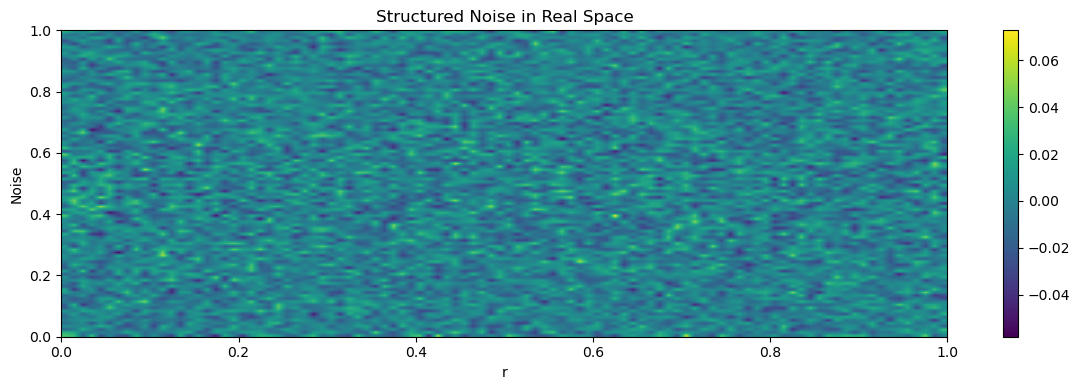

In [182]:
# Plot noise
plt.figure(figsize=(12, 4))
plt.imshow(results[0], extent=[0, 1, 0, 1], origin='lower', cmap='viridis', aspect='auto', interpolation="bilinear")
plt.title("Structured Noise in Real Space")
plt.xlabel("r")
plt.ylabel("Noise")
#plt.grid(True)
plt.tight_layout()
plt.colorbar()
plt.show()

In [ ]:
# add frequency dependence again? - if yes see create_data_1d.ipynb 